# 2.0 Feature Selection, Engineering and Analysis

In [256]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [103]:
# import cleaned data and make it into a pandas Data Frame
with open('json_/cleaned_data_2.json') as json_file:
    data = json.load(json_file)

In [104]:
df = pd.read_json(data)

#### Ensure Data Was Imported Correctly

In [105]:
df.shape

(9121, 25)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9121 entries, 0 to 999
Data columns (total 25 columns):
backers_count               9121 non-null int64
converted_pledged_amount    9121 non-null int64
country                     9121 non-null object
created_at                  9121 non-null datetime64[ns]
currency                    9121 non-null object
current_currency            9121 non-null object
deadline                    9121 non-null int64
disable_communication       9121 non-null bool
fx_rate                     9121 non-null float64
goal                        9121 non-null float64
id                          9121 non-null int64
is_starrable                9121 non-null bool
launched_at                 9121 non-null datetime64[ns]
name                        9121 non-null object
pledged                     9121 non-null float64
spotlight                   9121 non-null bool
staff_pick                  9121 non-null bool
state                       9121 non-null object
state

In [107]:
df.head(1)

,backers_count,converted_pledged_amount,country,created_at,currency,current_currency,deadline,disable_communication,fx_rate,goal,...,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,cat_name,cat_slug,loc_state
0,6,1847,GB,2015-04-03,GBP,USD,1430956800000,False,1.30399,7000.0,...,False,False,canceled,2015-04-19,1.491538,"{""web"":{""project"":""https://www.kickstarter.com...",1842.049134,Ready-to-wear,fashion/ready-to-wear,England


In [108]:
# deadline's date appears to have changed format, as such it is returned to desired format
df['deadline'] = pd.to_datetime(df['deadline'], unit='ms')
df['deadline'] = pd.to_datetime(df['deadline'].dt.date)

In [109]:
# Get names of indexes with states of canceled, live and suspended and remove them as they are
# not an indication of success or failure. Cancellation and suspension could be for various reasons other
# than failure.
indexNames = df[(df['state'] == 'canceled')|(df['state'] == 'live')|(df['state'] == 'suspended')].index
# Delete these row indexes from dataFrame
df.drop(indexNames,0,inplace=True)

In [110]:
# Check data target balance
df['state'].value_counts()

successful    5174
failed        3171
Name: state, dtype: int64

In [111]:
# I would like to convert countries into continents 
df['country'].value_counts();

In [112]:
for index, row in df.iterrows():
    if df.loc[index,'country'] == 'US' or df.loc[index,'country'] == 'CA':
        df.loc[index,'country'] = 'NAmerica'
    elif df.loc[index,'country'] == 'NZ' or df.loc[index,'country'] == 'AU':
        df.loc[index,'country'] = 'Aus'
    elif df.loc[index,'country'] == 'JP' or df.loc[index,'country'] == 'CH' or df.loc[index,'country'] == 'HK' or df.loc[index,'country'] == 'SG':
        df.loc[index,'country'] = 'Aisa'
    elif df.loc[index,'country'] == 'MX':
        df.loc[index,'country'] = 'SAmerica'
    else:
        df.loc[index,'country'] = 'Euro'

In [113]:
df.reset_index(drop=True, inplace=True)

In [142]:
df.shape

(8345, 27)

#### Create new features

In [114]:
# time_allowed feature is the time between creating the kickstarter project and ending it in days
df['time_allowed'] = df['deadline']-df['created_at']

In [115]:
# which is then converted into an integer
df.time_allowed = df.time_allowed.dt.days

In [116]:
# ratio of funding pledged/goal is used to normalise the date and replace 'goal' and 'pledge' amount
# df['pledge/goal'] = (df['converted_pledged_amount']/df['goal'])

In [117]:
# another ration of goal and time_allowed is attempted
df['goal/time_allowed'] = (df['goal']/df['time_allowed'])

In [118]:
# Below I am inspecting the data to gauge presence of outliers and understand what is the range I am looking at

In [119]:
df.goal.describe();

In [120]:
df.time_allowed.describe()

count    8345.000000
mean       82.278850
std       137.822285
min         3.000000
25%        33.000000
50%        47.000000
75%        73.000000
max      2431.000000
Name: time_allowed, dtype: float64

In [121]:
df['goal/time_allowed'].describe()

count    8.345000e+03
mean     7.158406e+02
std      1.939620e+04
min      1.063830e-02
25%      2.697095e+01
50%      8.108108e+01
75%      2.333333e+02
max      1.612903e+06
Name: goal/time_allowed, dtype: float64

In [122]:
df['goal/time_allowed'].value_counts()

166.666667     87
33.333333      57
16.666667      54
100.000000     53
83.333333      48
50.000000      47
333.333333     46
125.000000     46
142.857143     44
66.666667      42
32.258065      35
62.500000      35
156.250000     34
250.000000     32
161.290323     32
111.111111     32
312.500000     31
151.515152     30
90.909091      30
200.000000     30
500.000000     29
25.000000      29
16.129032      29
20.000000      28
27.777778      28
45.454545      28
55.555556      27
31.250000      27
294.117647     26
322.580645     25
               ..
0.434783        1
105.236842      1
85.937500       1
13.477089       1
23.170732       1
13.414634       1
780.487805      1
52.960526       1
6.038647        1
1311.475410     1
80.213904       1
13.432836       1
265.957447      1
254.545455      1
1.652893        1
127.906977      1
9.202454        1
54.151625       1
2.586207        1
5.434783        1
22.026432       1
42.746114       1
947.368421      1
181.159420      1
12.833333 

In [129]:
outlier_plot_data = df[(df['time_allowed'] < 5000) & (df['goal'] < 2e6)]

In [144]:
len(outlier_plot_data)-df.shape[0]

-12

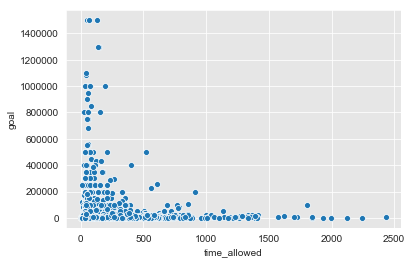

In [130]:
sns.scatterplot('time_allowed', 'goal',data=outlier_plot_data)

In [156]:
# (df[df['goal/time_allowed'] > 4.5].index)|
outliers_index = list(df[df['time_allowed'] > 2500].index)+list(df[df['goal'] > 2e6].index)

In [157]:
len(outliers_index)

11

In [158]:
df.drop(outliers_index,0,inplace=True)

In [159]:
df.reset_index(drop=True, inplace=True)

In [160]:
df.shape

(8334, 27)

In [188]:
df['log_goal'] = np.log(df['goal'])
df['log_time_allowed'] = np.log(df['time_allowed'])

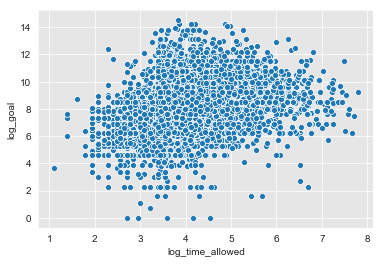

In [324]:
sns.scatterplot('log_time_allowed', 'log_goal',data=df)

In [345]:
df.to_csv(r'df_df+log.csv')

In [162]:
# df['pledge/goal'].describe()

In [163]:
# plt.hist(df['pledge/goal'], bins=10)


In [164]:
# # binning pledge/goal ration into bins
# bins = [-0.01, 0.5, 1.0 , 1.5, 2.0, 2.5, 3.0, 5.0]
# bins_pledgeGoal = pd.cut(df['pledge/goal'], bins)
# bins_pledgeGoal = bins_pledgeGoal.cat.as_ordered()
# df["pledge/goal"]=bins_pledgeGoal
# df["pledge/goal"];

In [165]:
# df.isna().sum().sum()

In [166]:
# Pick contineous features

In [189]:
X_c = df[['log_time_allowed', 'log_goal']]

In [190]:
# X_c.to_csv(r'csv_\X_c.csv')

In [191]:
# Pick categotical features

In [192]:
X_d = pd.get_dummies(df[['cat_slug', 'staff_pick', 'country']], drop_first=True, prefix_sep='_')

In [193]:
X_d.columns

Index(['staff_pick', 'cat_slug_art/ceramics', 'cat_slug_art/conceptual art',
       'cat_slug_art/digital art', 'cat_slug_art/illustration',
       'cat_slug_art/installations', 'cat_slug_art/mixed media',
       'cat_slug_art/painting', 'cat_slug_art/performance art',
       'cat_slug_art/public art',
       ...
       'cat_slug_theater/experimental', 'cat_slug_theater/festivals',
       'cat_slug_theater/immersive', 'cat_slug_theater/musical',
       'cat_slug_theater/plays', 'cat_slug_theater/spaces', 'country_Aus',
       'country_Euro', 'country_NAmerica', 'country_SAmerica'],
      dtype='object', length=172)

In [194]:
# rename 'pledge/goal_...' as they pose issues when running models

In [195]:
# X_d.rename(columns={'pledge/goal_(0.5, 1.0]': 'p/g_low','pledge/goal_(1.0, 1.5]': 'p/g_high', 'pledge/goal_(1.5, 2.0]': 'p/g_vhigh',  'pledge/goal_(2.0, 2.5]': 'p/g_shigh', 'pledge/goal_(2.0, 2.5]':'p/g_sdhigh', 'pledge/goal_(2.5, 3.0]': 'p/g_uhigh', 'pledge/goal_(3.0, 5.0]': 'p/g_extraOrdinarlyHigh' }, inplace=True)

In [196]:
# X_d.to_csv(r'csv_\X_d.csv')

In [197]:
# Join X_c and X_d Features
X = pd.concat([X_c,X_d],1)
X;

In [198]:
# Set target to binary
y = pd.get_dummies(df[['state']], drop_first=True)
y;

In [199]:
# y.to_csv(r'csv_\y.csv')

In [200]:
X.isna().sum().sum()

0

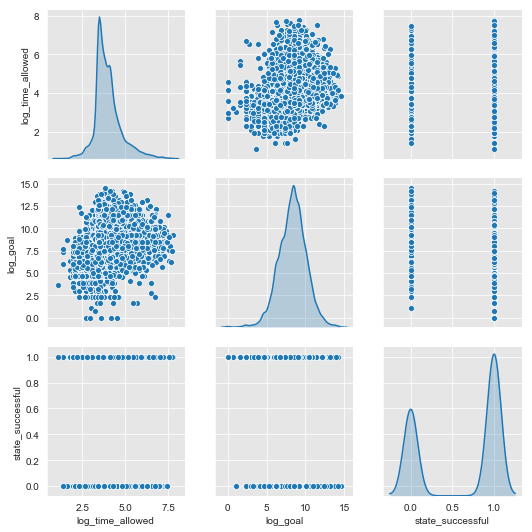

In [201]:
# Plot pair relationships
sns.pairplot(pd.concat([X_c,y],1), diag_kind="kde", height=2.5)

In [202]:
(pd.concat([X_c,y],1)).corr()

,log_time_allowed,log_goal,state_successful
log_time_allowed,1.000000,0.251105,0.030201
log_goal,0.251105,1.000000,-0.228176
state_successful,0.030201,-0.228176,1.000000


# 3.0 Modelling

The following models will be used:
   - Logistic regression
   - Random forest
   - XGBoost

### 3.1 Split, Train, Test

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)

### 3.2 Random Forest

In [204]:
forest_vanilla = RandomForestClassifier()
forest_vanilla.fit(X_train, y_train)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [205]:
y_hat_train_v_rf = forest_vanilla.predict(X_train)
y_hat_test_v_rf = forest_vanilla.predict(X_test)
accuracy_score(y_train, y_hat_train_v_rf), accuracy_score(y_test, y_hat_test_v_rf)

(0.9818275330018859, 0.7536985205917633)

In [206]:
print(confusion_matrix(y_train, y_hat_train_v_rf))

[[2196   29]
 [  77 3531]]


In [207]:
print(confusion_matrix(y_test, y_hat_test_v_rf))

[[ 668  267]
 [ 349 1217]]


In [208]:
# hyperparameter tuning 

In [209]:
# varying number of max_depth parameter and setting criterion='entropy'
array32 = list(range(1,100))
clf_list = []
for i in array32:
    clf_choc = RandomForestClassifier(criterion='entropy', max_depth=i);  # Train the classifier using training data 
    clf_list.append(clf_choc.fit(X_train, y_train))
auc_list_train = []
for i in clf_list:
    y_pred = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred)
    auc_list_train.append(auc(false_positive_rate, true_positive_rate))
auc_list_test = []
for i in clf_list:
    y_pred1 = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred1)
    auc_list_test.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironsch

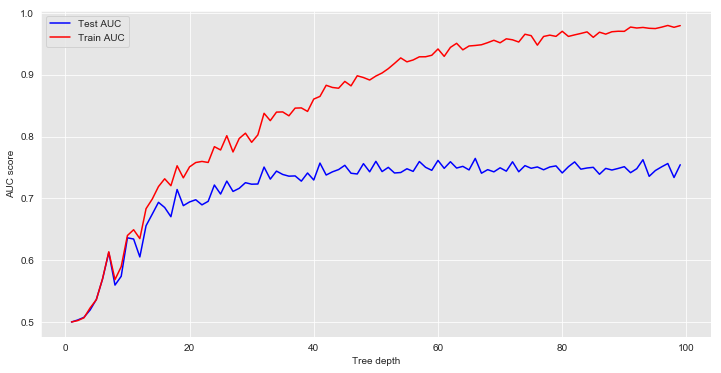

In [210]:
plt.figure(figsize=(12,6))
plt.plot(array32, auc_list_test, 'b', label='Test AUC')
plt.plot(array32, auc_list_train, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [211]:
# varying number of min_samples_split parameter and setting criterion='entropy'
array1 = list(map(lambda x: round(x,1), np.arange(0.1,1.0,0.1)))
clf_list_strawberry = []
for i in array1:
    clf_strawberry = RandomForestClassifier(criterion='entropy', min_samples_split = i)  # Train the classifier using training data 
    clf_list_strawberry.append(clf_strawberry.fit(X_train, y_train))
auc_list_test_strawberry = []
for i in clf_list_strawberry:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_strawberry.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_strawberry = []
for i in clf_list_strawberry:
    y_pred1 = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred1)
    auc_list_train_strawberry.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

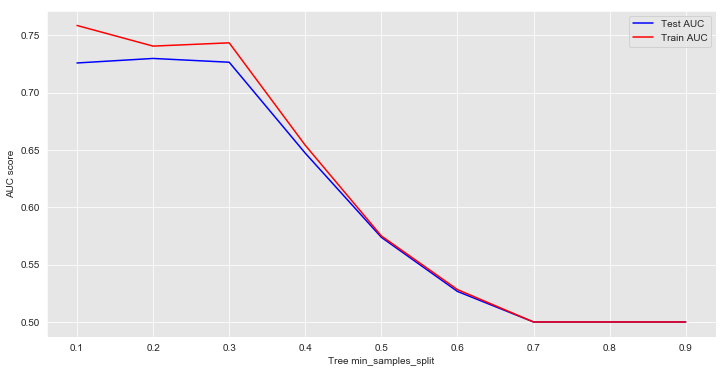

In [212]:
plt.figure(figsize=(12,6))
plt.plot(array1, auc_list_test_strawberry, 'b', label='Test AUC')
plt.plot(array1, auc_list_train_strawberry, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree min_samples_split')
plt.legend()
plt.show()

In [213]:
# varying number of min_samples_leaf parameter and setting criterion='entropy'
array05 = list(map(lambda x: round(x,1), np.arange(0.1,0.5,0.1)))
clf_list_cookiencream = []
for i in array05:
    clf_cookiencream = RandomForestClassifier(criterion='entropy', min_samples_leaf = i)  # Train the classifier using training data 
    clf_list_cookiencream.append(clf_cookiencream.fit(X_train, y_train))
auc_list_test_cookiencream = []
for i in clf_list_cookiencream:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_cookiencream.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_cookiencream = []
for i in clf_list_cookiencream:
    y_pred1 = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred1)
    auc_list_train_cookiencream.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

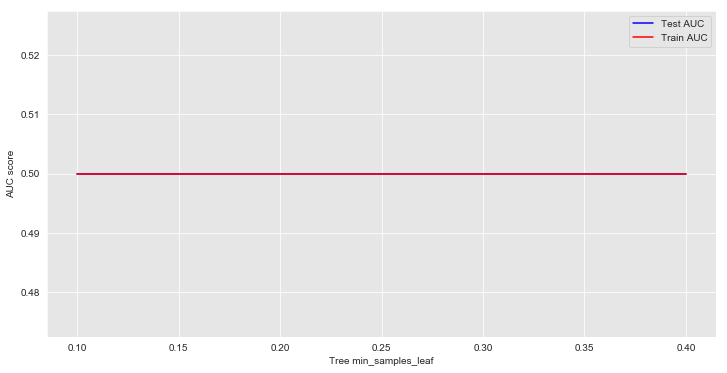

In [214]:
plt.figure(figsize=(12,6))
plt.plot(array05, auc_list_test_cookiencream, 'b', label='Test AUC')
plt.plot(array05, auc_list_train_cookiencream, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree min_samples_leaf')
plt.legend()
plt.show()

In [74]:
# varying number of max_features parameter and setting criterion='entropy'
array200 = range(1,int(len(X.columns)/2))
clf_list_peanutbutter = []
for i in array200:
    clf_peanutbutter = RandomForestClassifier(criterion='entropy', max_features = i)  # Train the classifier using training data 
    clf_list_peanutbutter.append(clf_peanutbutter.fit(X_train, y_train))
auc_list_test_peanutbutter = []
for i in clf_list_peanutbutter:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_peanutbutter.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_peanutbutter = []
for i in clf_list_peanutbutter:
    y_pred1 = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred1)
    auc_list_train_peanutbutter.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/flatironsch

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (86,) and (69,)

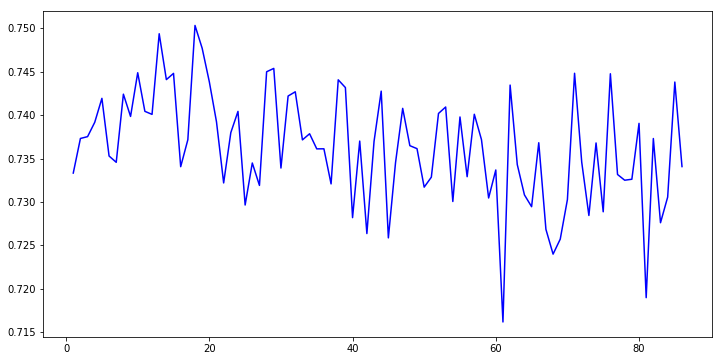

In [75]:
plt.figure(figsize=(12,6))
plt.plot(array200, auc_list_test_peanutbutter, 'b', label='Test AUC')
plt.plot(array200, auc_list_train_peanutbutter, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree max_features')
plt.legend()
plt.show()

In [215]:
clf_rf = RandomForestClassifier(criterion='entropy', max_depth=69, min_samples_split =0.2)
clf_rf.fit(X_train, y_train)
y_hat_rf_train = clf_rf.predict(X_train)
y_hat_rf_test = clf_rf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_rf_test)
auc(false_positive_rate, true_positive_rate)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7024139296958769

In [244]:
round(accuracy_score(y_train, y_hat_rf_train)*100,1), round(accuracy_score(y_test, y_hat_rf_test)*100,1)

(76.3, 74.9)

In [217]:
# very slight imporvement to Vanilla on test
print(confusion_matrix(y_test, y_hat_test_v_rf))

[[ 668  267]
 [ 349 1217]]


### 3.3 Logistic Regression

In [218]:
logreg_vanilla = LogisticRegression()
model_log = logreg_vanilla.fit(X_train, y_train)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [219]:
y_score_lr_v = logreg_vanilla.decision_function(X_test)
y_hat_test_lr_v = logreg_vanilla.predict(X_test)
y_hat_train_lr_v = logreg_vanilla.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_test, y_score_lr_v)

In [249]:
print('AUC: {}'.format(auc(fpr, tpr)))
print(confusion_matrix(y_train, y_hat_train_lr_v))
print(confusion_matrix(y_test, y_hat_test_lr_v))

AUC: 0.8779983745500985
[[1661  564]
 [ 608 3000]]
[[ 697  238]
 [ 272 1294]]


In [245]:
# accuracy enhanced slightly when compared to RandomForest
round(accuracy_score(y_train, y_hat_train_lr_v)*100,1), round(accuracy_score(y_test, y_hat_test_lr_v)*100,1)

(79.9, 79.6)

In [245]:
# accuracy enhanced slightly when compared to RandomForest
round(accuracy_score(y_train, y_hat_train_lr_v)*100,1), round(accuracy_score(y_test, y_hat_test_lr_v)*100,1)

(79.9, 79.6)

AUC: 0.8772518969273533


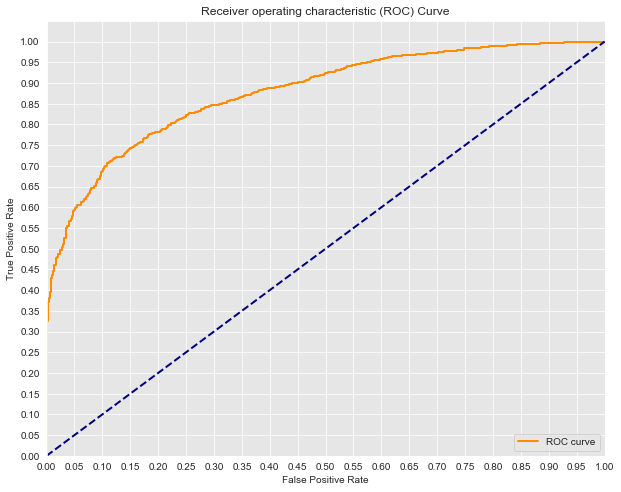

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [223]:
# hyperparameter tuing

In [224]:
# Change C parameter
C_param_range = [0.001,0.01,0.1,1,10,100]
clf_list = []
for i in C_param_range:
    clf_choc = LogisticRegression(C=i);  # Train the classifier using training data 
    clf_list.append(clf_choc.fit(X_train, y_train))
auc_list_train_lr_choc = []
for i in clf_list:
    y_pred = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred)
    auc_list_train_lr_choc.append(auc(false_positive_rate, true_positive_rate))
auc_list_test_lr_choc = []
for i in clf_list:
    y_pred1 = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred1)
    auc_list_test_lr_choc.append(auc(false_positive_rate, true_positive_rate))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, w

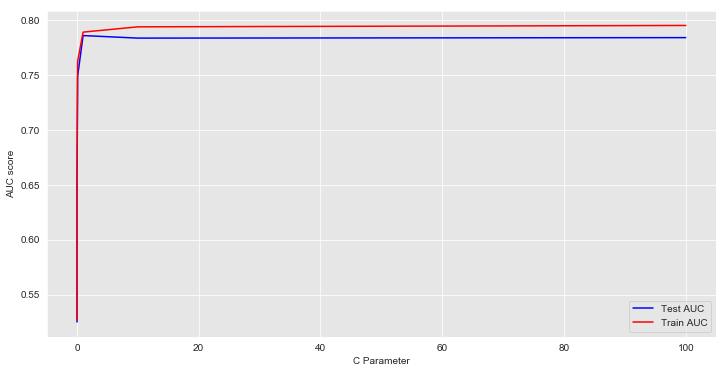

In [225]:
plt.figure(figsize=(12,6))
plt.plot(C_param_range, auc_list_test_lr_choc, 'b', label='Test AUC')
plt.plot(C_param_range, auc_list_train_lr_choc, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('C Parameter')
plt.legend()
plt.show()

In [226]:
# Change penlty and corresponding solver type
penalty_list = {'l1':'liblinear', 'l2':'liblinear', 'none':'lbfgs'}
clf_list_strawberry = []
for k,v in penalty_list.items():
    print(k,v)
    clf_strawberry = LogisticRegression(penalty = k,solver=v)  # Train the classifier using training data 
    clf_list_strawberry.append(clf_strawberry.fit(X_train, y_train))
auc_list_test_strawberry_lr = []
for i in clf_list_strawberry:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_strawberry_lr.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_strawberry_lr = []
for i in clf_list_strawberry:
    y_pred1 = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred1)
    auc_list_train_strawberry_lr.append(auc(false_positive_rate, true_positive_rate))

l1 liblinear
l2 liblinear


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


none lbfgs


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [227]:
auc_list_test_strawberry_lr, auc_list_train_strawberry_lr

([0.7848279959841826, 0.7858818065714618, 0.7824891921240805],
 [0.7885966267221405, 0.7890012207578664, 0.7925255362614915])

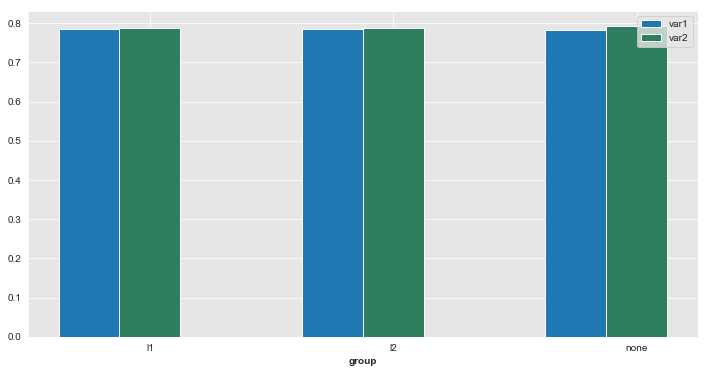

In [228]:
# set width of bar
plt.figure(figsize=(12,6))
barWidth = 0.25
 
# set height of bar
bars1 = auc_list_test_strawberry_lr
bars2 = auc_list_train_strawberry_lr
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='#2d7f5e', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(penalty_list.keys()))
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [229]:
logreg_ = LogisticRegression(penalty='l1', solver='liblinear')
model_log = logreg_.fit(X_train, y_train)

y_score_lr = logreg_.decision_function(X_test)
y_hat_test_lr = logreg_.predict(X_test)
y_hat_train_lr = logreg_.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_test, y_score_lr)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [230]:
print('AUC: {}'.format(auc(fpr, tpr)))
print(confusion_matrix(y_train, y_hat_train_lr))
print(confusion_matrix(y_test, y_hat_test_lr))

AUC: 0.8779983745500985
[[1673  552]
 [ 631 2977]]
[[ 701  234]
 [ 283 1283]]


In [247]:
print('validation: '+str(round(accuracy_score(y_train, y_hat_train_lr)*100,1))+'%. Test: '+str(round(accuracy_score(y_test, y_hat_test_lr)*100,1))+'%.')

validation: 79.7%. Test: 79.3%.


AUC: 0.8779983745500985


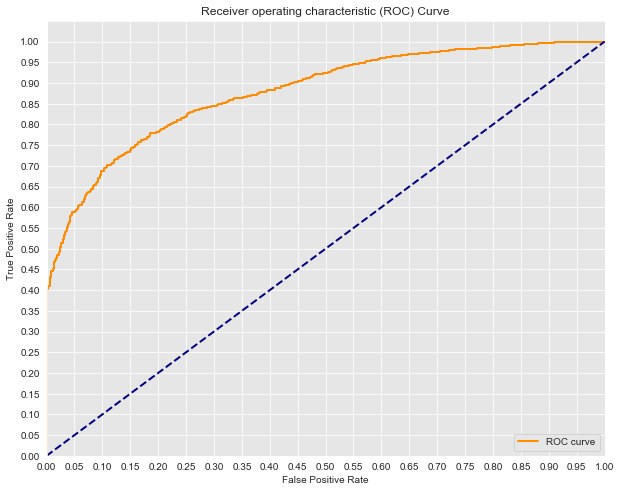

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [94]:
# Little difference - keep as Vanilla

### 3.4 XGBoost

In [233]:
XGBoost = xgb.XGBClassifier()
XGBoost.fit(X_train, y_train)
y_hat_train = XGBoost.predict(X_train)
y_hat_test = XGBoost.predict(X_test)
training_accuracy = accuracy_score(y_train, y_hat_train)
val_accuracy = accuracy_score(y_test, y_hat_test)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Training Accuracy: 76.29%
Validation accuracy: 75.89%


In [234]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [235]:
grid_clf = GridSearchCV(XGBoost, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X, y)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_hat_train = grid_clf.predict(X_train)
y_hat_test = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, y_hat_train)
val_accuracy = accuracy_score(y_test, y_hat_test)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d ar

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 100
subsample: 0.7

Training Accuracy: 77.04%
Validation accuracy: 78.17%


In [82]:
# Grid Search found the following optimal parameters: 
# learning_rate: 0.1
# max_depth: 6
# min_child_weight: 10
# n_estimators: 100
# subsample: 0.7

# Training Accuracy: 77.04%
# Validation accuracy: 78.17%

In [236]:
from sklearn.dummy import DummyClassifier

In [237]:
DC = DummyClassifier(strategy='most_frequent')

In [238]:
DC.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [239]:
DC.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [248]:
accuracy_score(y_test, DC.predict(X_test))

0.6261495401839264

Logestic Regression Vanilla Model returns best result with a very small margin. I will inspect the False Postives and Negatives from the model in the next section. See summary of accuracy results below.

In [298]:
# Random Forest Vanilla
print('Training Model Accuracy: '+str(round(accuracy_score(y_train, y_hat_train_v_rf)*100,1))+'%. Model on testing data: '+str(round(accuracy_score(y_test, y_hat_test_v_rf)*100,1))+'%.')

Training Model Accuracy: 98.2%. Model on testing data: 75.4%.


In [297]:
# Random Forest Hyper-Optimised
print('Training Model Accuracy: '+str(round(accuracy_score(y_train, y_hat_rf_train)*100,1))+'%. Model on testing data: '+str(round(accuracy_score(y_test, y_hat_rf_test)*100,1))+'%.')

Training Model Accuracy: 76.3%. Model on testing data: 74.9%.


In [296]:
# Logistic Regression Vanilla
print('Training Model Accuracy: '+str(round(accuracy_score(y_train, y_hat_train_lr_v)*100,1))+'%. Model on testing data: '+str(round(accuracy_score(y_test, y_hat_test_lr_v)*100,1))+'%.')

Training Model Accuracy: 79.9%. Model on testing data: 79.6%.


In [295]:
# Logistic Regression Hyper-Opstimised
print('Training Model Accuracy: '+str(round(accuracy_score(y_train, y_hat_train_lr)*100,1))+'%. Model on testing data: '+str(round(accuracy_score(y_test, y_hat_test_lr)*100,1))+'%.')

Training Model Accuracy: 79.7%. Model on testing data: 79.3%.


In [ ]:
#XGBoost
# Training Accuracy: 77.04%
# Validation accuracy: 78.17%

# Accuracy Analysis

In [280]:
trian_df = pd.DataFrame(index=y_train.index)

In [282]:
trian_df['y_train'] = y_train['state_successful']

In [283]:
# prediction results from Logistic Regression Vanilla Model
trian_df['y_train_pred'] = y_hat_train_lr_v

In [300]:
trian_df.head(2)

,y_train,y_train_pred
7918,0,1
2582,0,0


In [301]:
# checking confusion matrix results matching one done previously
confusion_matrix(trian_df['y_train'], trian_df['y_train_pred'])

array([[1661,  564],
       [ 608, 3000]])

In [288]:
# false positives stored below
false_pos = trian_df[(trian_df.y_train == 0) & (trian_df.y_train_pred == 1)]

In [302]:
false_pos.head(2)

,y_train,y_train_pred
7918,0,1
5905,0,1


In [343]:
false_pos_df = false_pos.join(df, how='inner')

In [344]:
false_pos_df.groupby(['country', 'cat_slug']).agg({'goal':'mean','time_allowed':'mean'})

goal  time_allowed
country  cat_slug                                                 
Aisa     art/conceptual art              9900.000000     60.000000
         fashion/accessories              500.000000     24.000000
         fashion/apparel                  500.000000     20.000000
         film & video/science fiction    5000.000000     30.000000
         games/playing cards            12000.000000    155.000000
         technology/gadgets            100000.000000    252.000000
         technology/hardware            80000.000000     45.000000
Aus      art/public art                 35000.000000     47.000000
         comics/anthologies             11000.000000    204.000000
         film & video/horror             1500.000000    102.000000
         music/punk                      1600.000000     30.000000
         photography/photobooks          2187.500000     34.000000
         photography/places              1000.000000    115.000000
         publishing/literary journals    1000.000000     60.000000
         technology/camera equipment    45000.000000     37.000000
         technology/gadgets             25000.000000     73.000000
         technology/sound               10000.000000     38.000000
         technology/wearables          102500.000000     65.500000
Euro     art/digital art                  100.000000     62.000000
         art/installations               1500.000000     44.000000
         art/mixed media                  200.000000    128.000000
         art/painting                     400.000000    112.000000
         art/performance art              294.000000     34.200000
         comics/graphic novels           2750.000000    316.000000
         crafts/crochet                  1000.000000     34.000000
         crafts/glass                    3500.000000    110.000000
         crafts/knitting                 2150.000000     50.000000
         crafts/pottery                  2223.000000     50.000000
         crafts/printing                  200.000000     41.000000
         crafts/woodworking              1000.000000    104.500000
...                                              ...           ...
NAmerica publishing/anthologies          1732.500000     52.500000
         publishing/art books            4000.000000    185.000000
         publishing/literary journals    1027.500000     39.500000
         publishing/periodicals         10000.000000     30.000000
         publishing/poetry                700.000000     50.000000
         publishing/radio & podcasts     9871.153846     61.076923
         publishing/young adult           100.000000     30.000000
         publishing/zines                 625.000000    216.000000
         technology/3d printing          7233.333333     49.666667
         technology/camera equipment    40000.000000     67.000000
         technology/diy electronics     24000.000000    116.400000
         technology/flight              50000.000000     70.000000
         technology/gadgets             45965.625000    146.687500
         technology/hardware            28786.363636    242.181818
         technology/makerspaces         25000.000000     57.000000
         technology/robots               6000.000000    406.000000
         technology/software              550.000000     41.000000
         technology/sound               61666.666667    157.000000
         technology/space exploration    2000.000000     65.000000
         technology/wearables           19000.000000     71.250000
         theater/experimental            7016.666667    104.000000
         theater/festivals               7150.000000     45.000000
         theater/immersive               5750.000000     59.000000
         theater/musical                10450.000000     53.785714
         theater/plays                   4463.333333     47.466667
         theater/spaces                 22166.666667     43.000000
SAmerica comics/anthologies              1700.000000     28.000000
         film & video/webser

In [321]:
false_pos_df.head(2)

,y_train,y_train_pred,log_time_allowed,log_goal,staff_pick,cat_slug_art/ceramics,cat_slug_art/conceptual art,cat_slug_art/digital art,cat_slug_art/illustration,cat_slug_art/installations,...,cat_slug_theater/experimental,cat_slug_theater/festivals,cat_slug_theater/immersive,cat_slug_theater/musical,cat_slug_theater/plays,cat_slug_theater/spaces,country_Aus,country_Euro,country_NAmerica,country_SAmerica
7918,0,1,5.062595,8.987197,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5905,0,1,4.110874,6.907755,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [322]:
false_pos_df.describe()

,y_train,y_train_pred,log_time_allowed,log_goal,cat_slug_art/ceramics,cat_slug_art/conceptual art,cat_slug_art/digital art,cat_slug_art/illustration,cat_slug_art/installations,cat_slug_art/mixed media,...,cat_slug_theater/experimental,cat_slug_theater/festivals,cat_slug_theater/immersive,cat_slug_theater/musical,cat_slug_theater/plays,cat_slug_theater/spaces,country_Aus,country_Euro,country_NAmerica,country_SAmerica
count,564.0,564.0,564.000000,564.000000,564.000000,564.000000,564.000000,564.0,564.000000,564.000000,...,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,0.0,1.0,3.965330,7.767394,0.003546,0.005319,0.007092,0.0,0.003546,0.005319,...,0.012411,0.008865,0.010638,0.033688,0.028369,0.005319,0.026596,0.193262,0.760638,0.007092
std,0.0,0.0,0.833097,1.830078,0.059496,0.072803,0.083991,0.0,0.059496,0.072803,...,0.110811,0.093820,0.102683,0.180585,0.166171,0.072803,0.161042,0.395208,0.427073,0.083991
min,0.0,1.0,1.945910,2.302585,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,1.0,3.465736,6.396930,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.0,1.0,3.761200,7.824046,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.0,1.0,4.248495,8.987197,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.0,1.0,7.217443,12.899220,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [339]:
false_neg = trian_df[(trian_df.y_train == 1) & (trian_df.y_train_pred == 0)]
false_neg_df = false_pos.join(df, how='inner')
false_neg_df.head(1)

,y_train,y_train_pred,backers_count,converted_pledged_amount,country,created_at,currency,current_currency,deadline,disable_communication,...,static_usd_rate,urls,usd_pledged,cat_name,cat_slug,loc_state,time_allowed,goal/time_allowed,log_goal,log_time_allowed
7918,0,1,5,53,NAmerica,2015-12-14,USD,USD,2016-05-20,False,...,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",53.0,Journalism,journalism,CA,158,50.632911,8.987197,5.062595


In [341]:
false_neg_df.groupby(['country', 'cat_slug']).agg({'goal':'mean','time_allowed':'mean'})

goal  time_allowed
country  cat_slug                                                 
Aisa     art/conceptual art              9900.000000     60.000000
         fashion/accessories              500.000000     24.000000
         fashion/apparel                  500.000000     20.000000
         film & video/science fiction    5000.000000     30.000000
         games/playing cards            12000.000000    155.000000
         technology/gadgets            100000.000000    252.000000
         technology/hardware            80000.000000     45.000000
Aus      art/public art                 35000.000000     47.000000
         comics/anthologies             11000.000000    204.000000
         film & video/horror             1500.000000    102.000000
         music/punk                      1600.000000     30.000000
         photography/photobooks          2187.500000     34.000000
         photography/places              1000.000000    115.000000
         publishing/literary journals    1000.000000     60.000000
         technology/camera equipment    45000.000000     37.000000
         technology/gadgets             25000.000000     73.000000
         technology/sound               10000.000000     38.000000
         technology/wearables          102500.000000     65.500000
Euro     art/digital art                  100.000000     62.000000
         art/installations               1500.000000     44.000000
         art/mixed media                  200.000000    128.000000
         art/painting                     400.000000    112.000000
         art/performance art              294.000000     34.200000
         comics/graphic novels           2750.000000    316.000000
         crafts/crochet                  1000.000000     34.000000
         crafts/glass                    3500.000000    110.000000
         crafts/knitting                 2150.000000     50.000000
         crafts/pottery                  2223.000000     50.000000
         crafts/printing                  200.000000     41.000000
         crafts/woodworking              1000.000000    104.500000
...                                              ...           ...
NAmerica publishing/anthologies          1732.500000     52.500000
         publishing/art books            4000.000000    185.000000
         publishing/literary journals    1027.500000     39.500000
         publishing/periodicals         10000.000000     30.000000
         publishing/poetry                700.000000     50.000000
         publishing/radio & podcasts     9871.153846     61.076923
         publishing/young adult           100.000000     30.000000
         publishing/zines                 625.000000    216.000000
         technology/3d printing          7233.333333     49.666667
         technology/camera equipment    40000.000000     67.000000
         technology/diy electronics     24000.000000    116.400000
         technology/flight              50000.000000     70.000000
         technology/gadgets             45965.625000    146.687500
         technology/hardware            28786.363636    242.181818
         technology/makerspaces         25000.000000     57.000000
         technology/robots               6000.000000    406.000000
         technology/software              550.000000     41.000000
         technology/sound               61666.666667    157.000000
         technology/space exploration    2000.000000     65.000000
         technology/wearables           19000.000000     71.250000
         theater/experimental            7016.666667    104.000000
         theater/festivals               7150.000000     45.000000
         theater/immersive               5750.000000     59.000000
         theater/musical                10450.000000     53.785714
         theater/plays                   4463.333333     47.466667
         theater/spaces                 22166.666667     43.000000
SAmerica comics/anthologies              1700.000000     28.000000
         film & video/webser

In [83]:
# inspect and explain
# label figures 